<a href="https://colab.research.google.com/github/olonok69/LLM_Notebooks/blob/main/LLMOps/vLLM/vllm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# vLLM
vLLM is a fast and easy-to-use library for LLM inference and serving.

- https://docs.vllm.ai/en/latest/

- https://arxiv.org/pdf/2309.06180

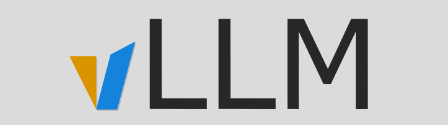


# The Secret Sauce: PagedAttention
In vLLM, we identify that the performance of LLM serving is bottlenecked by memory. In the autoregressive decoding process, all the input tokens to the LLM produce their attention key and value tensors, and these tensors are kept in GPU memory to generate next tokens. These cached key and value tensors are often referred to as KV cache. The KV cache is

- Large: Takes up to 1.7GB for a single sequence in LLaMA-13B.
- Dynamic: Its size depends on the sequence length, which is highly variable and unpredictable. As a result, efficiently managing the KV cache presents a significant challenge. We find that existing systems waste 60% – 80% of memory due to fragmentation and over-reservation.

To address this problem, we introduce PagedAttention, an attention algorithm inspired by the classic idea of virtual memory and paging in operating systems. Unlike the traditional attention algorithms, PagedAttention allows storing continuous keys and values in non-contiguous memory space. Specifically, PagedAttention partitions the KV cache of each sequence into blocks, each block containing the keys and values for a fixed number of tokens. During the attention computation, the PagedAttention kernel identifies and fetches these blocks efficiently.


The LLM can only sample and generate new tokens one by one, and the generation
process of each new token depends on all the previous tokens
in that sequence, specifically their key and value vectors. In
this sequential generation process, the key and value vectors
of existing tokens are often cached for generating future
tokens, known as KV cache. Note that the KV cache of one
token depends on all its previous tokens. This means that the
KV cache of the same token appearing at different positions
in a sequence will be different.


# Install
- https://docs.vllm.ai/en/latest/getting_started/installation.html
- https://blog.vllm.ai/2023/06/20/vllm.html


###  Supported Models
vLLM supports a variety of generative and embedding models from HuggingFace (HF) Transformers.

https://docs.vllm.ai/en/latest/models/supported_models.html

In [1]:
! pip install vllm pyngrok  -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 108.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8

In [2]:
! pip install -U flash-attn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 35.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flash-attn: filename=flash_attn-2.6.3-cp310-cp310-linux_x86_64.whl size=187309225 sha256=237ef9c6157db394e1ddde4ba609a21ebb98382377a27041edc09318801a6f24
  Stored in directory: /root/.cache/pip/wheels/7e/e3/c3/89c7a2f3c4adc07cd1c675f8bb7b9ad4d18f64a72bccdfe826
Successfully built flash-attn


# Offline Inference
This class includes a tokenizer, a language model (possibly distributed across multiple GPUs), and GPU memory space allocated for intermediate states (aka KV cache). Given a batch of prompts and sampling parameters, this class generates texts from the model, using an intelligent batching mechanism and efficient memory management.

https://docs.vllm.ai/en/latest/dev/offline_inference/llm.html

In [2]:

from vllm.assets.image import ImageAsset
from vllm.assets.video import VideoAsset
from vllm import LLM, SamplingParams

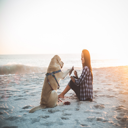

In [3]:
from PIL import Image
import requests
import torch
from torchvision import io
from typing import Dict
import pprint

# Image
url = "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg"
image = Image.open(requests.get(url, stream=True).raw)
image.resize((128, 128))

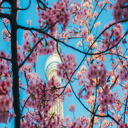

In [4]:
image2 = ImageAsset("cherry_blossom") \
            .pil_image.convert("RGB")
image2.resize((128, 128))

In [5]:
img_question = "What is the content of this image?"

mm_input ={
            "data": image,
            "question": img_question,
        }

data = mm_input["data"]
question = mm_input["question"]

prompt = ("<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n"
              "<|im_start|>user\n<|vision_start|><|image_pad|><|vision_end|>"
              f"{question}<|im_end|>\n"
              "<|im_start|>assistant\n")
stop_token_ids = None

In [6]:
llm = LLM(model="Qwen/Qwen2-VL-2B-Instruct",max_model_len=8192,
          gpu_memory_utilization=0.75,
        max_num_seqs=5,
        # Note - mm_processor_kwargs can also be passed to generate/chat calls
        mm_processor_kwargs={
            "min_pixels": 28 * 28,
            "max_pixels": 1280 * 28 * 28,
        },
    )

config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

INFO 11-01 17:38:39 llm_engine.py:237] Initializing an LLM engine (v0.6.3.post1) with config: model='Qwen/Qwen2-VL-2B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2-VL-2B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=8192, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=Qwen/Qwen2-VL-2B-Instruct, num_scheduler_steps=1, chunked_prefill_enabled=False multi_step_stream_outputs=True, enab

tokenizer_config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

INFO 11-01 17:38:42 model_runner.py:1056] Starting to load model Qwen/Qwen2-VL-2B-Instruct...
WARNING 11-01 17:38:42 utils.py:513] Current `vllm-flash-attn` has a bug inside vision module, so we use xformers backend instead. You can run `pip install flash-attn` to use flash-attention backend.
WARNING 11-01 17:38:42 utils.py:513] Current `vllm-flash-attn` has a bug inside vision module, so we use xformers backend instead. You can run `pip install flash-attn` to use flash-attention backend.
WARNING 11-01 17:38:42 utils.py:513] Current `vllm-flash-attn` has a bug inside vision module, so we use xformers backend instead. You can run `pip install flash-attn` to use flash-attention backend.
WARNING 11-01 17:38:42 utils.py:513] Current `vllm-flash-attn` has a bug inside vision module, so we use xformers backend instead. You can run `pip install flash-attn` to use flash-attention backend.
WARNING 11-01 17:38:42 utils.py:513] Current `vllm-flash-attn` has a bug inside vision module, so we use x

model-00001-of-00002.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/429M [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/56.4k [00:00<?, ?B/s]

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 11-01 17:40:19 model_runner.py:1067] Loading model weights took 4.1273 GB
WARNING 11-01 17:40:19 utils.py:1401] The following intended overrides are not keyword-only args and and will be dropped: {'min_pixels', 'max_pixels'}
WARNING 11-01 17:40:19 utils.py:1401] The following intended overrides are not keyword-only args and and will be dropped: {'min_pixels', 'max_pixels'}
WARNING 11-01 17:40:19 utils.py:1401] The following intended overrides are not keyword-only args and and will be dropped: {'min_pixels', 'max_pixels'}
WARNING 11-01 17:40:19 utils.py:1401] The following intended overrides are not keyword-only args and and will be dropped: {'min_pixels', 'max_pixels'}
WARNING 11-01 17:40:19 utils.py:1401] The following intended overrides are not keyword-only args and and will be dropped: {'min_pixels', 'max_pixels'}
WARNING 11-01 17:40:19 utils.py:1401] The following intended overrides are not keyword-only args and and will be dropped: {'min_pixels', 'max_pixels'}
WARNING 11-01 1

/usr/local/lib/python3.10/dist-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/usr/local/lib/python3.10/dist-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


INFO 11-01 17:40:22 gpu_executor.py:122] # GPU blocks: 55820, # CPU blocks: 9362
INFO 11-01 17:40:22 gpu_executor.py:126] Maximum concurrency for 8192 tokens per request: 109.02x
INFO 11-01 17:40:25 model_runner.py:1395] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 11-01 17:40:25 model_runner.py:1399] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 11-01 17:40:28 model_runner.py:1523] Graph capturing finished in 3 secs.


In [7]:
sampling_params = SamplingParams(temperature=0.2,
                                     max_tokens=64,
                                     stop_token_ids=stop_token_ids)

In [8]:
inputs = {
            "prompt": prompt,
            "multi_modal_data": {
                "image": data
            },
        }

In [9]:
import datetime

In [10]:
time1 = datetime.datetime.now()
outputs = llm.generate(inputs, sampling_params=sampling_params)
time2 = datetime.datetime.now()
print(f"\n\ntime in seconds: {(time2-time1).total_seconds()}")

WARNING 11-01 17:42:55 utils.py:1401] The following intended overrides are not keyword-only args and and will be dropped: {'min_pixels', 'max_pixels'}


chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 11-01 17:42:56 utils.py:1401] The following intended overrides are not keyword-only args and and will be dropped: {'min_pixels', 'max_pixels'}


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it, est. speed input: 2937.73 toks/s, output: 45.62 toks/s]



time in seconds: 2.724338


In [11]:
for o in outputs:
    generated_text = o.outputs[0].text
    pprint.pprint(generated_text)

('The image shows a woman sitting on a sandy beach with a large dog. The dog '
 'is wearing a harness and is reaching up to give the woman a high-five. The '
 'woman is smiling and appears to be enjoying the moment. The background '
 'features the ocean and a clear sky.')


In [12]:
import torch
import gc
del llm
gc.collect()
torch.cuda.empty_cache()
gc.collect()

0

In [13]:
from huggingface_hub import hf_hub_download



In [14]:
def run_gguf_inference(model_path):
    PROMPT_TEMPLATE = "<|system|>\n{system_message}</s>\n<|user|>\n{prompt}</s>\n<|assistant|>\n"  # noqa: E501
    system_message = "You are a friendly chatbot who always responds in the style of a pirate."  # noqa: E501
    # Sample prompts.
    prompts = [
        "How many helicopters can a human eat in one sitting?",
        "What's the future of AI?",
    ]
    prompts = [
        PROMPT_TEMPLATE.format(system_message=system_message, prompt=prompt)
        for prompt in prompts
    ]
    # Create a sampling params object.
    sampling_params = SamplingParams(temperature=0, max_tokens=128)

    # Create an LLM.
    llm = LLM(model=model_path,
              tokenizer="TinyLlama/TinyLlama-1.1B-Chat-v1.0",
              gpu_memory_utilization=0.75)


    # Print the outputs.
    return llm, sampling_params, prompts

In [15]:
repo_id = "TheBloke/TinyLlama-1.1B-Chat-v1.0-GGUF"
filename = "tinyllama-1.1b-chat-v1.0.Q4_0.gguf"
model = hf_hub_download(repo_id, filename=filename)

# create llm and run inference
llm, sampling_params, prompts = run_gguf_inference(model)


time1 = datetime.datetime.now()
outputs = llm.generate(prompts, sampling_params)
time2 = datetime.datetime.now()
print(f"\n\ntime in seconds: {(time2-time1).total_seconds()}")

tinyllama-1.1b-chat-v1.0.Q4_0.gguf:   0%|          | 0.00/638M [00:00<?, ?B/s]

INFO 11-01 17:43:49 config.py:1664] Downcasting torch.float32 to torch.float16.
WARNING 11-01 17:43:57 config.py:321] gguf quantization is not fully optimized yet. The speed can be slower than non-quantized models.
INFO 11-01 17:43:57 llm_engine.py:237] Initializing an LLM engine (v0.6.3.post1) with config: model='/root/.cache/huggingface/hub/models--TheBloke--TinyLlama-1.1B-Chat-v1.0-GGUF/snapshots/52e7645ba7c309695bec7ac98f4f005b139cf465/tinyllama-1.1b-chat-v1.0.Q4_0.gguf', speculative_config=None, tokenizer='TinyLlama/TinyLlama-1.1B-Chat-v1.0', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=LoadFormat.GGUF, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=gguf, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

INFO 11-01 17:44:06 model_runner.py:1056] Starting to load model /root/.cache/huggingface/hub/models--TheBloke--TinyLlama-1.1B-Chat-v1.0-GGUF/snapshots/52e7645ba7c309695bec7ac98f4f005b139cf465/tinyllama-1.1b-chat-v1.0.Q4_0.gguf...


/usr/local/lib/python3.10/dist-packages/torch/nested/__init__.py:220: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  return _nested.nested_tensor(


INFO 11-01 17:44:14 model_runner.py:1067] Loading model weights took 0.5980 GB
INFO 11-01 17:44:14 gpu_executor.py:122] # GPU blocks: 85595, # CPU blocks: 11915
INFO 11-01 17:44:14 gpu_executor.py:126] Maximum concurrency for 2048 tokens per request: 668.71x
INFO 11-01 17:44:14 model_runner.py:1395] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 11-01 17:44:14 model_runner.py:1399] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 11-01 17:44:39 model_runner.py:1523] Graph capturing finished in 25 secs.


Processed prompts: 100%|██████████| 2/2 [00:00<00:00,  2.89it/s, est. speed input: 160.58 toks/s, output: 318.26 toks/s]



time in seconds: 0.697624


In [16]:
for output in outputs:
    prompt = output.prompt
    generated_text = output.outputs[0].text
    pprint.pprint(f"Prompt: {prompt!r}, Generated text: {generated_text!r}")

("Prompt: '<|system|>\\nYou are a friendly chatbot who always responds in the "
 'style of a pirate.</s>\\n<|user|>\\nHow many helicopters can a human eat in '
 "one sitting?</s>\\n<|assistant|>\\n', Generated text: 'There is no specific "
 'number of helicopters that a human can eat in one sitting. The amount of '
 'food that a human can consume is determined by their body weight, energy '
 'needs, and physical activity levels. However, some studies suggest that '
 'consuming a large amount of food in one sitting can lead to overeating and '
 'weight gain. It is recommended to consume a balanced diet and limit the '
 "amount of food consumed in one sitting.'")
('Prompt: "<|system|>\\nYou are a friendly chatbot who always responds in the '
 "style of a pirate.</s>\\n<|user|>\\nWhat's the future of "
 'AI?</s>\\n<|assistant|>\\n", Generated text: \'The future of AI is exciting '
 'and promising, with many exciting developments and applications in various '
 'fields. Here are some of the

In [23]:
#del llm
gc.collect()
torch.cuda.empty_cache()
gc.collect()

0

# OpenAI Compatible Server
vLLM provides an HTTP server that implements OpenAI’s Completions and Chat API.

In [18]:
from google.colab import userdata
import os
HF_TOKEN = userdata.get('HF_TOKEN')
os.environ['HF_TOKEN'] = HF_TOKEN

In [20]:
#HF_TOKEN

In [21]:
from google.colab import userdata
import os

NGROK =userdata.get('NGROK')


 #### export HF_TOKEN=hf_token
 #### vllm serve meta-llama/Llama-3.2-3B-Instruct --dtype  auto --gpu_memory_utilization .75


In [24]:
from pyngrok import ngrok

#get_ipython().system_raw("vllm serve meta-llama/Llama-3.2-3B-Instruct --dtype auto --api-key $HF_TOKEN &")


# Terminate open tunnels if exist
ngrok.kill()

In [25]:
ngrok.set_auth_token(NGROK)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="8000", proto="http", bind_tls=True)
print("vLLM  UI:", ngrok_tunnel.public_url)

vLLM  UI: https://cfd4-34-55-114-72.ngrok-free.app


In [26]:
import urllib
import requests
import json

In [46]:
headers = {'Content-Type':'application/json' }

In [48]:
prompt = """ Read the Instruction below and provide an answer

INSTRUCTION:
Question:
I bought a car 20 years ago, and its cost was 100000$.
Car's anual depreciation it is 5%.
Using the Percentage (Declining Balance) method, what it is the value of the car now ?
let's think step by step


### RESPONSE:
"""

In [49]:
data ={
  "model": "meta-llama/Llama-3.2-3B-Instruct",
  "prompt": prompt,
  "max_tokens": 1024,
  "temperature": .4
}
data = json.dumps(data)
data

'{"model": "meta-llama/Llama-3.2-3B-Instruct", "prompt": " Read the Instruction below and provide an answer\\n\\nINSTRUCTION:\\nQuestion:\\nI bought a car 20 years ago, and its cost was 100000$.\\nCar\'s anual depreciation it is 5%.\\nUsing the Percentage (Declining Balance) method, what it is the value of the car now ?\\nlet\'s think step by step\\n\\n\\n### RESPONSE:\\n", "max_tokens": 1024, "temperature": 0.4}'

In [50]:
url = "https://cfd4-34-55-114-72.ngrok-free.app/v1/completions"

In [51]:
body = str.encode(data)

In [52]:

req = urllib.request.Request(url, body, headers)

In [53]:
response = urllib.request.urlopen(req)

In [54]:
result = response.read()
pprint.pprint(result)

(b'{"id":"cmpl-647bc4c1fde345a093b1b4fee46b3ad8","object":"text_completion","cr'
 b'eated":1730486579,"model":"meta-llama/Llama-3.2-3B-Instruct","choices":[{"in'
 b'dex":0,"text":"## Step 1: Calculate the annual depreciation amount\\nTo f'
 b'ind the annual depreciation amount, we multiply the initial cost of the car '
 b'by the annual depreciation rate. Annual depreciation = Initial cost * Annual'
 b' depreciation rate = 100000 * 0.05 = 5000.\\n\\n## Step 2: Calculate the t'
 b'otal depreciation over 20 years\\nSince the car has been depreciating ann'
 b'ually for 20 years, we need to calculate the total depreciation over this pe'
 b'riod. Total depreciation = Annual depreciation * Number of years = 5000 * 20'
 b' = 100000.\\n\\n## Step 3: Calculate the current value of the car using th'
 b'e Declining Balance method\\nThe Declining Balance method involves subtra'
 b"cting the annual depreciation from the car's value at the beginning of each "
 b'year. However, since the total depreci

In [55]:
pprint.pprint(result.decode('utf-8'))

('{"id":"cmpl-647bc4c1fde345a093b1b4fee46b3ad8","object":"text_completion","created":1730486579,"model":"meta-llama/Llama-3.2-3B-Instruct","choices":[{"index":0,"text":"## '
 'Step 1: Calculate the annual depreciation amount\\nTo find the annual '
 'depreciation amount, we multiply the initial cost of the car by the annual '
 'depreciation rate. Annual depreciation = Initial cost * Annual depreciation '
 'rate = 100000 * 0.05 = 5000.\\n\\n## Step 2: Calculate the total '
 'depreciation over 20 years\\nSince the car has been depreciating annually '
 'for 20 years, we need to calculate the total depreciation over this period. '
 'Total depreciation = Annual depreciation * Number of years = 5000 * 20 = '
 '100000.\\n\\n## Step 3: Calculate the current value of the car using the '
 'Declining Balance method\\nThe Declining Balance method involves subtracting '
 "the annual depreciation from the car's value at the beginning of each year. "
 'However, since the total depreciation over 20 yea

In [57]:
respons =json.loads(result.decode('utf-8'))

In [58]:
pprint.pprint(respons['choices'][0]['text'])

('## Step 1: Calculate the annual depreciation amount\n'
 'To find the annual depreciation amount, we multiply the initial cost of the '
 'car by the annual depreciation rate. Annual depreciation = Initial cost * '
 'Annual depreciation rate = 100000 * 0.05 = 5000.\n'
 '\n'
 '## Step 2: Calculate the total depreciation over 20 years\n'
 'Since the car has been depreciating annually for 20 years, we need to '
 'calculate the total depreciation over this period. Total depreciation = '
 'Annual depreciation * Number of years = 5000 * 20 = 100000.\n'
 '\n'
 '## Step 3: Calculate the current value of the car using the Declining '
 'Balance method\n'
 'The Declining Balance method involves subtracting the annual depreciation '
 "from the car's value at the beginning of each year. However, since the total "
 'depreciation over 20 years is equal to the initial cost, the value of the '
 'car after 20 years will be zero. But, to follow the method, we can calculate '
 'the value at the end of the

In [ ]:
#! vllm serve meta-llama/Llama-3.2-3B-Instruct --dtype auto --api-key $HF_TOKEN &

In [ ]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()

In [38]:
from openai import OpenAI
client = OpenAI(
    base_url="https://cfd4-34-55-114-72.ngrok-free.app/v1",
    api_key=HF_TOKEN,
)



In [59]:
messages = [
    {"role": "system", "content": "You are a clever chatbot who answers questions and provide a rationale of your answers"},
    {"role": "user", "content":prompt},
]

In [60]:
completion = client.chat.completions.create(
  model="meta-llama/Llama-3.2-3B-Instruct",
  messages=messages,
  max_tokens=1024,
  temperature=.4,
  top_p=1.0,
  frequency_penalty=.1,
  presence_penalty=.1,
  stop=["###"]
)

#pprint.pprint(completion.choices[0].message)

In [61]:
pprint.pprint(completion.choices[0].message.content)

('To calculate the value of the car using the Declining Balance method, we '
 'need to calculate the depreciation for each year and subtract it from the '
 "previous year's value.\n"
 '\n'
 '**Step 1: Calculate the depreciation for the first year**\n'
 '\n'
 'Initial cost of the car = $100,000\n'
 'Annual depreciation rate = 5% = 0.05\n'
 '\n'
 'Depreciation for the first year = Initial cost x Depreciation rate\n'
 '= $100,000 x 0.05\n'
 '= $5,000\n'
 '\n'
 'Value of the car after the first year = Initial cost - Depreciation\n'
 '= $100,000 - $5,000\n'
 '= $95,000\n'
 '\n'
 '**Step 2: Calculate the depreciation for the second year**\n'
 '\n'
 'Value of the car after the first year = $95,000\n'
 'Depreciation rate = 5% = 0.05\n'
 '\n'
 'Depreciation for the second year = Value of the car after the first year x '
 'Depreciation rate\n'
 '= $95,000 x 0.05\n'
 '= $4,750\n'
 '\n'
 'Value of the car after the second year = Value of the car after the first '
 'year - Depreciation\n'
 '= $95,0